### A file about strange DE signals and cutting them, slightly unfinished

In [1]:
import numpy as np
from numpy.lib import recfunctions as rfn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import pandas as pd
from iminuit import cost,Minuit 
from jacobi import propagate
from scipy import stats
import random
import copy
import datetime
import os
import sys
import getpass
import warnings

#This doesn't actually remove the xedocs warnings, meep moop
warnings.filterwarnings("ignore", message=".*xedocs_version.*")

import strax
import straxen 
import cutax
# from cutax.cut_lists.basic import BasicCuts #Check later if I need this

#load plugins
sys.path.append('/home/ford2/project_code/plugins')
from SubTyping_Class import PeaksSubtypes
from Wrong_pS2_relabel import PS2_relabel
from pselection import AFTpS2
# from PeakPattern import PeakPatternFit

user = getpass.getuser()

straxen.print_versions()

/project2/lgrandi/xenonnt/software/cutax/v1.19.5/cutax/cut_lists/science.py:28: UserWarning: Removing cut <class 'cutax.cuts.s2_width.S2Width'>
  warnings.warn(f"Removing cut {cut}", UserWarning)
/project2/lgrandi/xenonnt/software/cutax/v1.19.5/cutax/cut_lists/science.py:28: UserWarning: Removing cut <class 'cutax.cuts.s2_width.S2Width'>
  warnings.warn(f"Removing cut {cut}", UserWarning)


,module,version,path,git
0,python,3.9.20,/opt/XENONnT/anaconda/envs/XENONnT_el7.sr1_wimp_unblind/bin/python,None
1,strax,1.6.5,/opt/XENONnT/anaconda/envs/XENONnT_el7.sr1_wimp_unblind/lib/python3.9/site-packages/strax,None
2,straxen,2.2.7,/opt/XENONnT/anaconda/envs/XENONnT_el7.sr1_wimp_unblind/lib/python3.9/site-packages/straxen,None
3,cutax,1.19.5,/project2/lgrandi/xenonnt/software/cutax/v1.19.5/cutax,None


In [2]:
from cutax.cuts.single_electron_selection import Strict_SESelection

In [3]:
st = cutax.xenonnt_offline(xedocs_version = "global_v12",
                           output_folder = f'/scratch/midway2/{user}/strax_data') 

st.storage.append(strax.DataDirectory('/project2/lgrandi/xenonnt/processed/', readonly = True))
st.storage.append(strax.DataDirectory('/project/lgrandi/xenonnt/processed/', readonly = True))
st.storage.append(strax.DataDirectory(f'/scratch/midway2/{user}/strax_data', readonly = True))

# st = cutax.contexts.xenonnt_offline(_auto_append_rucio_local=False,
#                                     _rucio_local_path='/dali/lgrandi/rucio', 
#                                     include_rucio_local=True, 
#                                     output_folder = f'/scratch/midway2/{user}/strax_data') 

plugins_to_register = [PeaksSubtypes, PS2_relabel, Strict_SESelection] #, PeakPatternFit
for i in plugins_to_register:
    st.register(i)
    print(i.provides, i.__version__)

st.storage

You specified _auto_append_rucio_local=True and you are not on dali compute nodes, so we will add the following rucio local path: /project/lgrandi/rucio/


/opt/XENONnT/anaconda/envs/XENONnT_el7.sr1_wimp_unblind/lib/python3.9/site-packages/straxen/config/preprocessors.py:16: UserWarning: From straxen version 2.1.0 onward, URLConfig parameterswill be sorted alphabetically before being passed to the plugins, this will change the lineage hash for non-sorted URLs. To load data processed with non-sorted URLs, you will need to use an older version.
  warnings.warn(
Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.


('subtype_mask',) 0.2.1
('pS2_relabel',) 0.0.0
('cut_se_peaks',) 0.0.2


[straxen.storage.rundb.RunDB (readonly: True),
 strax.storage.files.DataDirectory (readonly: True, path: /dali/lgrandi/xenonnt/raw, take_only: ('raw_records', 'raw_records_he', 'raw_records_aqmon', 'raw_records_nv', 'raw_records_aqmon_nv', 'raw_records_aux_mv', 'raw_records_mv')),
 strax.storage.files.DataDirectory (readonly: True, path: /dali/lgrandi/xenonnt/processed),
 strax.storage.files.DataDirectory (readonly: True, path: /project2/lgrandi/xenonnt/processed),
 strax.storage.files.DataDirectory (readonly: True, path: /project/lgrandi/xenonnt/processed),
 strax.storage.files.DataDirectory (path: /scratch/midway2/ford2/strax_data),
 straxen.storage.rucio_local.RucioLocalFrontend (readonly: True, path: /project/lgrandi/rucio/),
 strax.storage.files.DataDirectory (readonly: True, path: /project2/lgrandi/xenonnt/processed/),
 strax.storage.files.DataDirectory (readonly: True, path: /project/lgrandi/xenonnt/processed/),
 strax.storage.files.DataDirectory (readonly: True, path: /scratch/

In [4]:
run_id = '031681'

In [5]:
data = st.get_df(run_id,('peak_basics', 'cut_se_peaks'))


Removing old incomplete data in /scratch/midway2/ford2/strax_data/031681-cut_se_peaks-xhugp6vndq_temp


Loading plugins: |          | 0.00 % [00:00<?]

Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.


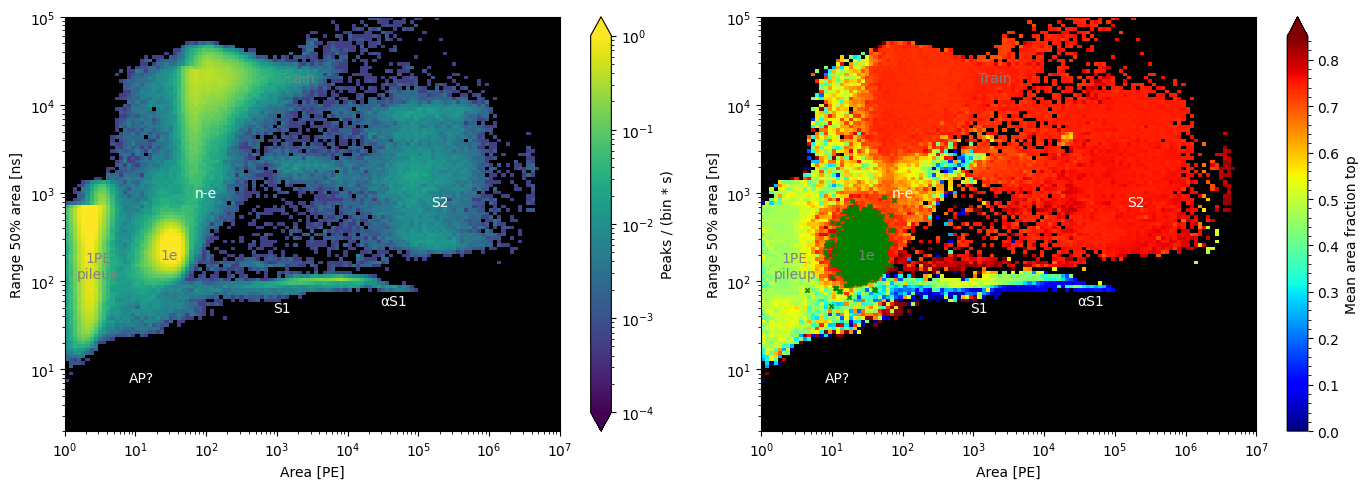

In [6]:
data = data[data['cut_se_peaks']]
data = data.sort_values(by = 'time')

st.plot_peaks_aft_histogram(run_id)

plt.scatter(data['area'], data['range_50p_area'], color = 'green', 
            marker = 'x', alpha = 0.9, s = 10)


In [7]:
peaks = st.get_array(run_id,
                     targets = ['peaks', 'peak_basics', 'peak_positions', 
                                'peak_proximity', 'subtype_mask', 'pS2_relabel'])


pS2s = peaks[np.isin(peaks['subtype'], [22, 24, 25])]
DEs = peaks[np.isin(peaks['subtype'], [20, 21, 23, 273, 28, 29])] #, 271, 272


#Will keep S1 and junk selected by subtypes regardless for now
S1s = peaks[np.isin(peaks['subtype'], [10, 11, 12, 13])]
Other = peaks[np.isin(peaks['subtype'], [0])] #Stuff labelled as 'junk' (by straxen itself, that is)

Loading plugins: |          | 0.00 % [00:00<?]

In [8]:
# def add_fields_structured(arr, time0):
#     # Define new dtype including the existing ones + new fields
#     new_dtype = arr.dtype.descr + [
#         ('time since start', 'f8'),  # float64
#         ('r', 'f8'),
#         ('theta', 'f8')
#     ]
    
#     # Create new empty array with the new dtype
#     new_arr = np.empty(arr.shape, dtype=new_dtype)
    
#     # Copy over existing data
#     for name in arr.dtype.names:
#         new_arr[name] = arr[name]

#     # Compute and assign new fields
#     new_arr['time since start'] = (arr['time'] - time0) / 1e6
#     new_arr['r'] = np.sqrt(arr['x']**2 + arr['y']**2)
#     new_arr['theta'] = np.arctan2(arr['y'], arr['x'])

#     return new_arr

# # Apply to each array
# time0 = peaks['time'][0]

# pS2s = add_fields_structured(pS2s, time0)
# DEs = add_fields_structured(DEs, time0)
# S1s = add_fields_structured(S1s, time0)
# Other = add_fields_structured(Other, time0)

1


Text(0, 0.5, 'Area Fraction Top')

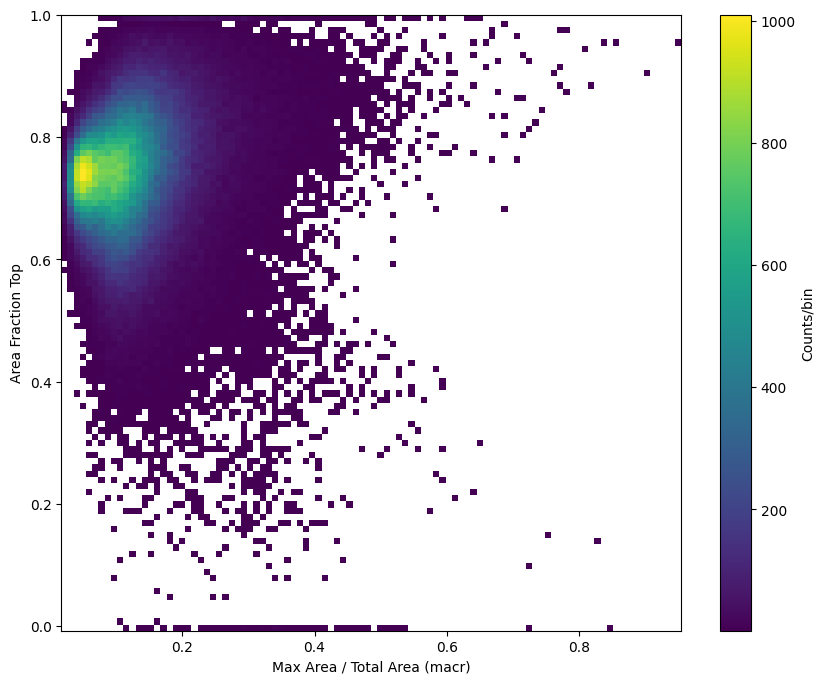

In [9]:
macr = DEs['area_per_channel'].max(axis = 1) / DEs['area']
aft = DEs['area_fraction_top']


# Filter out NaN, inf, or zero division
valid = np.isfinite(macr) & np.isfinite(aft)
print(len(macr[~valid]))

plt.figure(figsize=(10, 8))
plt.hist2d(macr[valid], aft[valid], bins = 100, cmap = 'viridis', 
            cmin = 1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Max Area / Total Area (macr)')
plt.ylabel('Area Fraction Top')

16011 removed from DEs


Text(0, 0.5, 'Area Fraction Top')

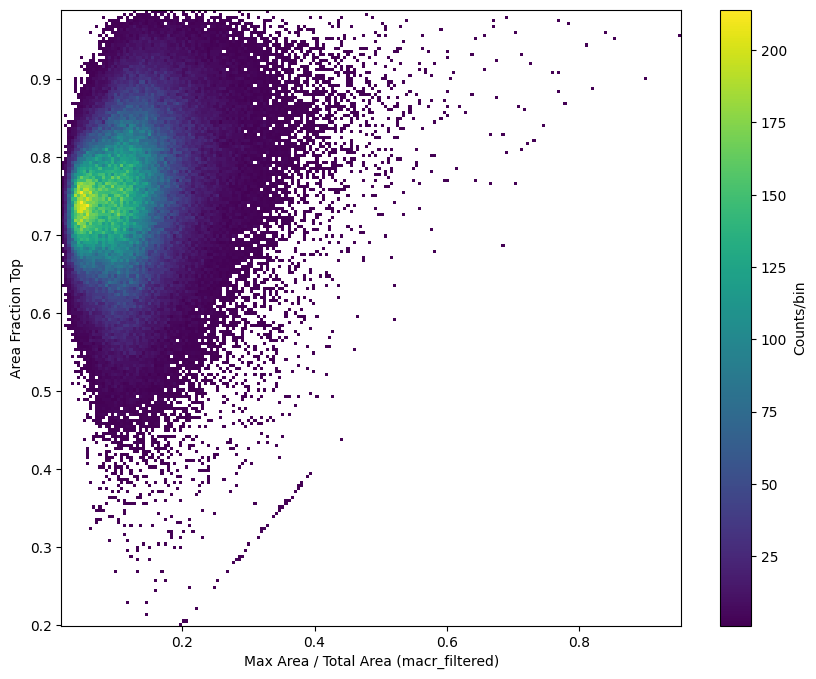

In [10]:
DEs_filtered = DEs[(DEs['max_pmt'] < 253) & (DEs['area_fraction_top'] < 0.99)]
print(f"{len(DEs) - len(DEs_filtered)} removed from DEs")

macr_filtered = DEs_filtered['area_per_channel'].max(axis = 1) / DEs_filtered['area']
aft_filt = DEs_filtered['area_fraction_top']

plt.figure(figsize=(10, 8))
plt.hist2d(macr_filtered, aft_filt, bins = 200, cmap = 'viridis', cmin = 1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Max Area / Total Area (macr_filtered)')
plt.ylabel('Area Fraction Top')

# macr_cut = DEs_cut['area_per_channel'].max(axis = 1) / DEs_cut['area']
# aft_cut = DEs_cut['area_fraction_top']

# # Filter out NaN, inf, or zero division
# valid_cut = np.isfinite(macr_cut) & np.isfinite(aft_cut)
# print(len(macr_cut[~valid_cut]))

# plt.figure(figsize=(10, 8))
# plt.hist2d(macr_cut[valid_cut], aft_cut[valid_cut], bins = 100, cmap = 'viridis', 
#             cmin = 1)
# plt.colorbar(label='Counts/bin')
# plt.xlabel('Max Area / Total Area (macr_cut)')
# plt.ylabel('Area Fraction Top (aft_cut)')


In [11]:
cut_mask = (
    (macr_filtered + 0.01 < aft_filt) #&
    # (macr_filtered < (aft_filt / 2)) #&
    # (macr_filtered < 0.3)
)
print(len(DEs_filtered))
# Apply the cuts
DEs_cut = DEs_filtered[cut_mask]
print(len(DEs_cut))

228389
228338


Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.


38


Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.
Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.
Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.
Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.


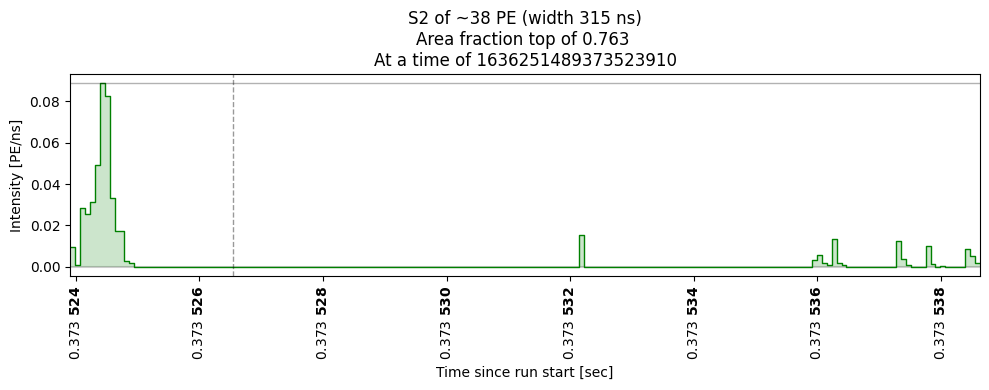

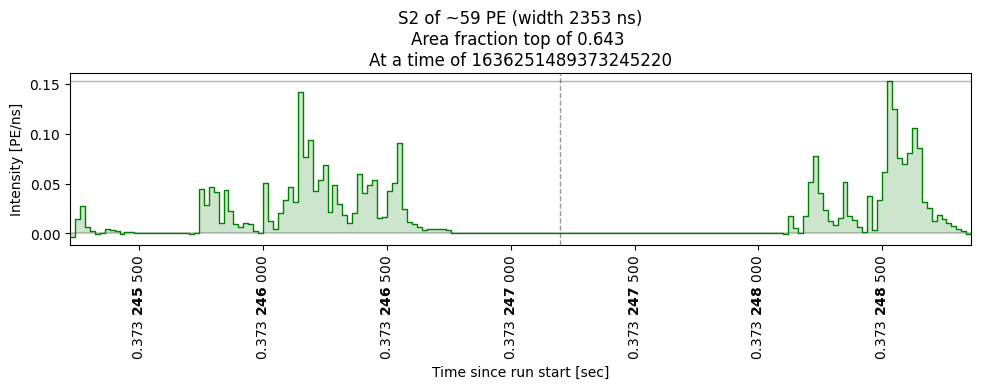

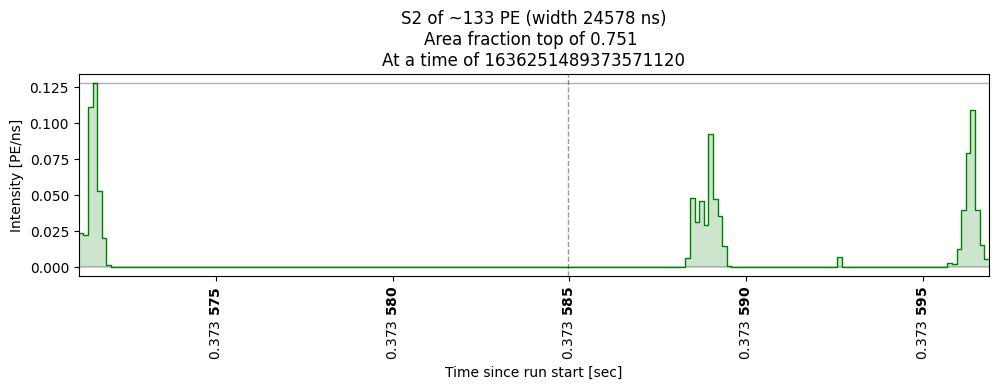

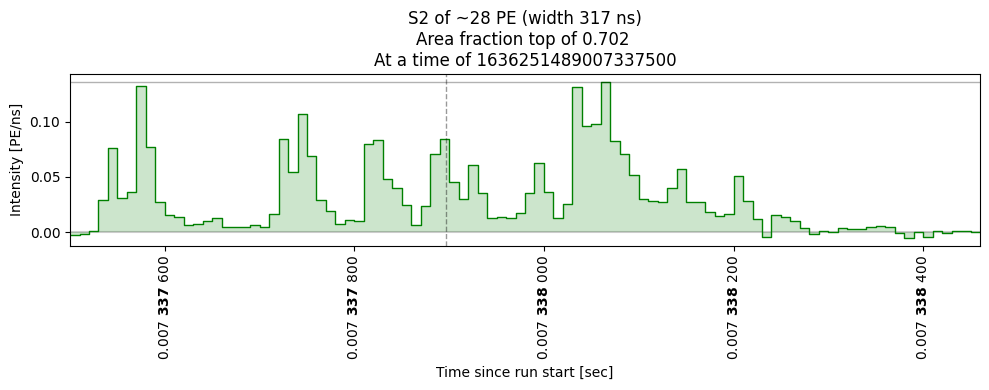

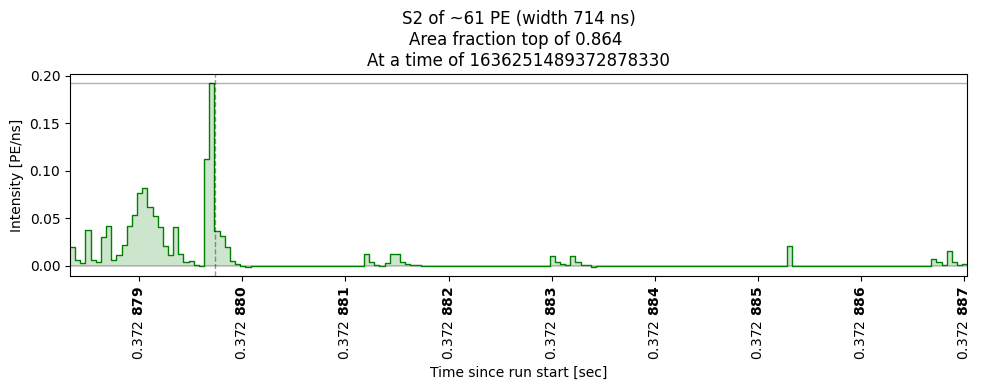

In [12]:
#Useful plot

weird_DEs = DEs_filtered[DEs_filtered['area_fraction_top'] == macr_filtered]
print(len(weird_DEs))

n = 5
indices = np.random.choice(len(weird_DEs), size = n, replace = False)

for i in indices:
    s = DEs_cut[i]
    start, stop = s["time"], s["endtime"]
    # start, stop = s["time"] - int(1e5), s["endtime"] + int(1e5)

    # st.plot_waveform(run_id, time_range = (start, stop))
    st.plot_peaks(run_id, time_range = (start, stop))
    
    # plt.yscale('log')
    plt.title(
        f'S{s["type"]} of ~{int(s["area"])} PE (width {int(s["range_50p_area"])} ns)\n'
        f'Area fraction top of {s["area_fraction_top"]:.3f} \n'
        f'At a time of {s["time"]}'
    )
    plt.tight_layout()

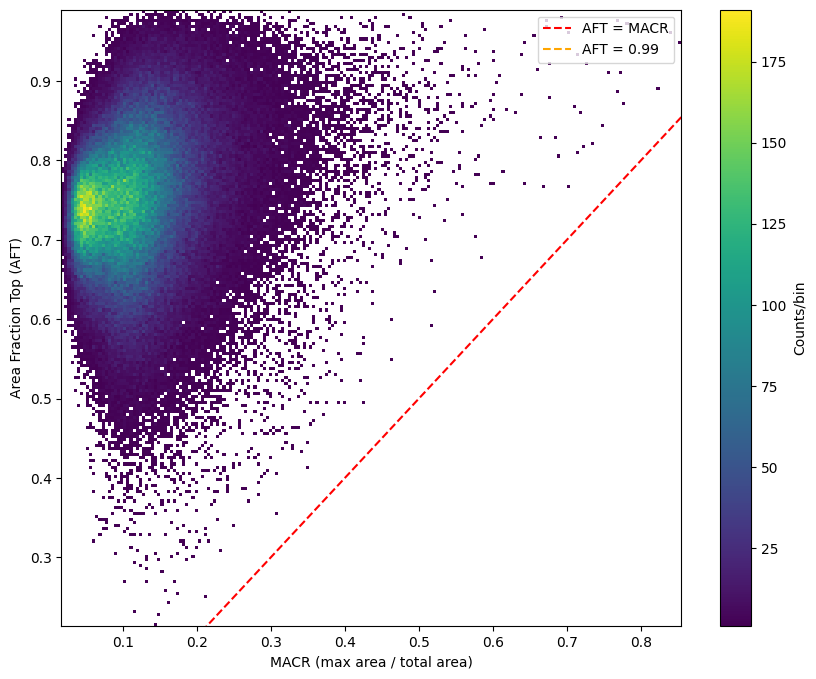

In [13]:
macr_cut = DEs_cut['area_per_channel'].max(axis = 1) / DEs_cut['area']
aft_cut = DEs_cut['area_fraction_top']

# Filter out NaN, inf, or zero division
# valid_cut = np.isfinite(macr_cut) & np.isfinite(aft_cut)
# print(len(macr_cut[~valid_cut]))

plt.figure(figsize=(10, 8))
plt.hist2d(macr_cut, aft_cut, bins=200, cmap='viridis', cmin=1)
plt.plot([0, 1], [0, 1], 'r--', label='AFT = MACR')
plt.axhline(0.99, color='orange', linestyle='--', label='AFT = 0.99')
plt.colorbar(label='Counts/bin')
plt.xlabel('MACR (max area / total area)')
plt.ylabel('Area Fraction Top (AFT)')
plt.legend()


Text(0.5, 1.0, 'Area vs Width for SEs')

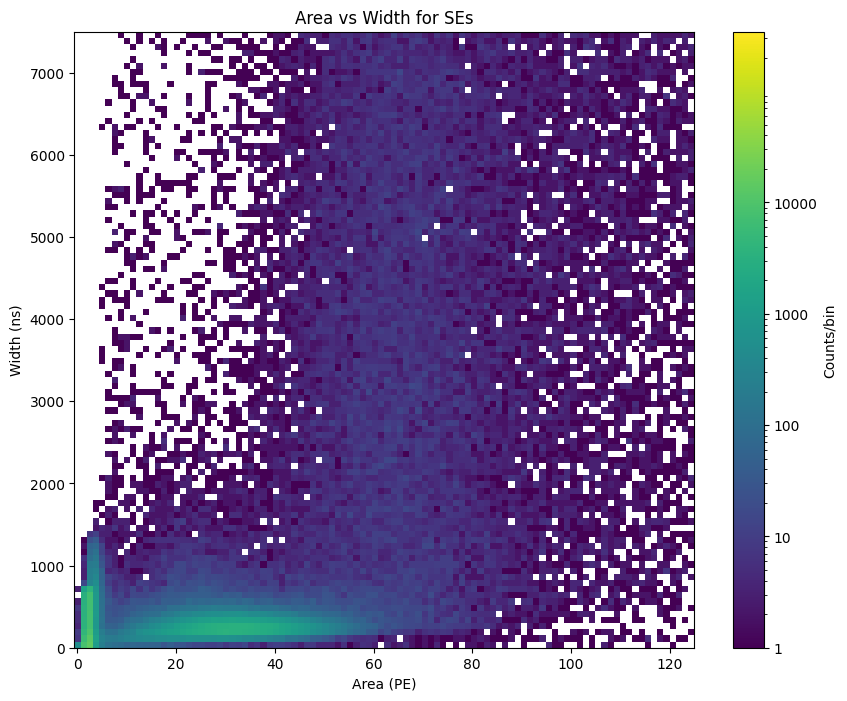

In [14]:
#Selecting SEs based on area < 125 PE, width < 7500 ns, and top pmt contributions (top PMTs are < 253)
SEs = peaks[(peaks['area'] < 125) & (peaks['range_50p_area'] < 7500) & (peaks['max_pmt'] < 253)] 



#Histogram of area vs range_50p_area:
plt.figure(figsize=(10, 8))
plt.hist2d(SEs['area'], SEs['range_50p_area'], bins=100, cmap='viridis', norm=LogNorm(vmin=1, vmax=SEs.shape[0]), cmin=1)
#Want to put a log scale on the color bar
plt.colorbar(label='Counts/bin', ticks=[1, 10, 100, 1000, 10000], format='%d')
# plt.colorbar(label='Counts/bin', 
plt.xlabel('Area (PE)')
plt.ylabel('Width (ns)')
plt.title('Area vs Width for SEs')


In [15]:
MACR = SEs['area_per_channel'].max(axis = 1) / SEs['area']

# Filter out NaN, inf, or zero division
valid = np.isfinite(MACR) & np.isfinite(aft)

plt.figure(figsize=(10, 8))
plt.hist2d(MACR[valid], aft[valid], bins=100, cmap='viridis', cmin=1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Max Area / Total Area (MACR)')
plt.ylabel('Area Fraction Top')

ValueError: operands could not be broadcast together with shapes (341603,) (244400,) 